# Transfer Learning example using Keras and Mobilenet# 
In this notebook I shall show you an example of using Mobilenet to classify images of dogs. I will then show you an example when it subtly misclassifies a bluetit. I will then retrain Mobilenet and employ transfer learning such that it can correctly classify the same input image.  Only two classifiers are employed. But this can be extended to as many as you want, limited to the amount of hardware and time you have available.

Lets load the necessary packages and libraries

In [19]:
import keras
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
import numpy as np
from IPython.display import Image
from keras.optimizers import Adam

We shall be using Mobilenet as it is lightweight
<img src="files/MobileNet architecture.png">


It is also very low maintence.
<img src="files/mobilenet_v1.png">

Source paper located here: https://arxiv.org/pdf/1704.04861.pdf
MobileNets: Efficient Convolutional Neural Networks for Mobile Vision
Applications, Howard et al, 2017


In [2]:
mobile = keras.applications.mobilenet.MobileNet()

In [3]:
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

Lets try some tests on images of different breed of dogs

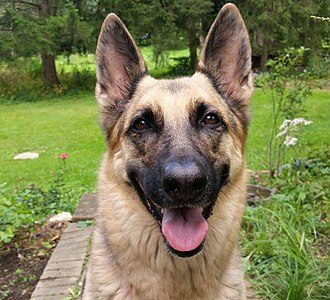

In [4]:
Image(filename='German_Shepherd.jpg') 

In [5]:
preprocessed_image = prepare_image('German_Shepherd.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n02106662', 'German_shepherd', 0.9796372),
  ('n02105162', 'malinois', 0.020184083),
  ('n02091467', 'Norwegian_elkhound', 0.00015799515),
  ('n02116738', 'African_hunting_dog', 5.2901587e-06),
  ('n02105251', 'briard', 3.9127376e-06)]]

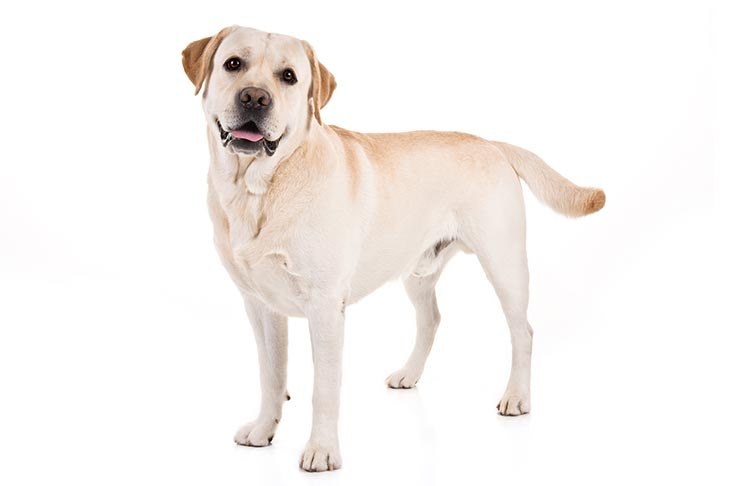

In [6]:
Image(filename='labrador1.jpg')

In [7]:
preprocessed_image = prepare_image('labrador1.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n02099712', 'Labrador_retriever', 0.73073703),
  ('n02087394', 'Rhodesian_ridgeback', 0.03984367),
  ('n02092339', 'Weimaraner', 0.03359009),
  ('n02109047', 'Great_Dane', 0.028944707),
  ('n02110341', 'dalmatian', 0.022403581)]]

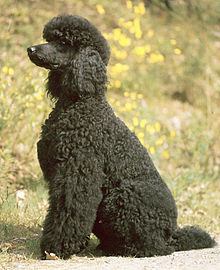

In [8]:
Image(filename='poodle1.jpg') 

In [9]:
preprocessed_image = prepare_image('poodle1.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n02113799', 'standard_poodle', 0.5650911),
  ('n02113712', 'miniature_poodle', 0.37279922),
  ('n02102973', 'Irish_water_spaniel', 0.053150617),
  ('n02113624', 'toy_poodle', 0.0072146286),
  ('n02093859', 'Kerry_blue_terrier', 0.0013652634)]]

So far so good. But lets try it on a type of bird, the blue tit.

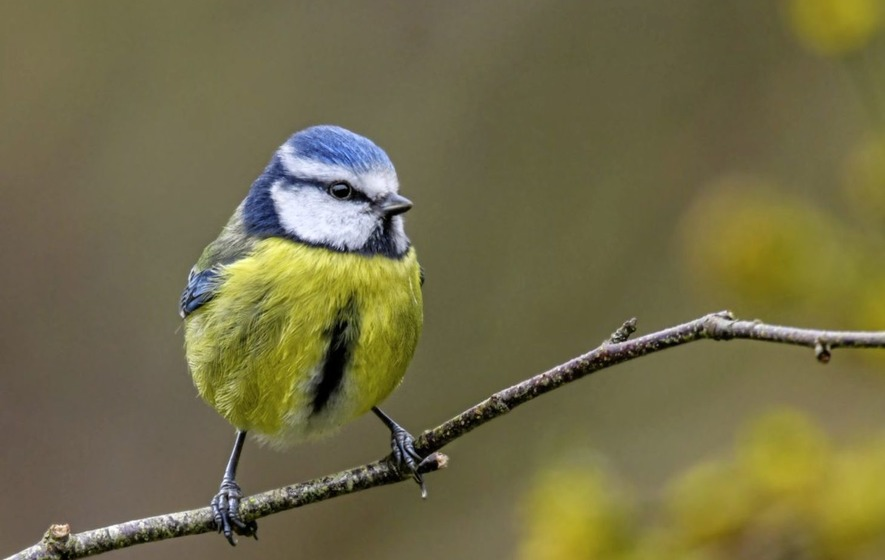

In [10]:
Image(filename='blue_tit.jpg') 

In [11]:
preprocessed_image = prepare_image('blue_tit.jpg')
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n01592084', 'chickadee', 0.95554715),
  ('n01530575', 'brambling', 0.012973112),
  ('n01828970', 'bee_eater', 0.012916375),
  ('n01532829', 'house_finch', 0.010978725),
  ('n01580077', 'jay', 0.0020677084)]]

You can see it could not recognise the blue tit. It mistaklenly classified the image as a chickadee. This is a native bird to North America, and is subtely different: 

<img src="files/220px-Poecile-atricapilla-001.jpg">

Lets now manipulate Mobilenetm the top few layers and employ transfer learning. To do this, we need to train it on some images. Here I will train it on Blue tits and Crows. But rather than manually downloading images of them, lets use Google Image Search and pull the images. To do this, there is a nice package we can import.

Check out https://github.com/hardikvasa/google-images-download

In [ ]:
!pip install google_images_download

In [ ]:
from google_images_download import google_images_download

In [ ]:
response = google_images_download.googleimagesdownload()

In [ ]:
arguments = {"keywords":"blue tit","limit":100,"print_urls":False,"format":"jpg", "size":">400*300"} 

In [ ]:
paths = response.download(arguments)

In [ ]:
arguments = {"keywords":"crow","limit":100,"print_urls":False, "format":"jpg", "size":">400*300"}

In [ ]:
paths = response.download(arguments)

Lets now use MobileNet as it is quite lightweight (17Mb), freeze the base layers and lets add and train the top few layers. Note only two classifiers.

In [14]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(2,activation='softmax')(x) #final layer with softmax activation

C:\Users\Ferhat\Anaconda3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [15]:
model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

Lets check the model architecture

In [16]:
for i,layer in enumerate(model.layers):
  print(i,layer.name)

0 input_2
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

We will use pre-trained weights as the model has been trained already on the Imagenet dataset. We ensure all the weights are non-trainable. We will only train the last few dense layers.

In [17]:
for layer in model.layers:
    layer.trainable=False
# or if we want to set the first 20 layers of the network to be non-trainable
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

Now lets load the training data into the ImageDataGenerator. Specify path, and it automatically sends the data for training in batches, simplifying the code.

In [20]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('C:/Users/Ferhat/Python Code/Workshop/Tensoorflow transfer learning/downloads',
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 188 images belonging to 2 classes.


Compile the model. Now lets train it. Should take less than two minutes on a GTX1070 GPU.

In [21]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   epochs=10)

Epoch 1/10
5/5 [==============================] - 5s 952ms/step - loss: 0.9098 - acc: 0.6562
Epoch 2/10
5/5 [==============================] - 3s 563ms/step - loss: 0.0503 - acc: 0.9686
Epoch 3/10
5/5 [==============================] - 3s 687ms/step - loss: 0.0236 - acc: 0.9930
Epoch 4/10
5/5 [==============================] - 4s 716ms/step - loss: 7.5358e-04 - acc: 1.0000
Epoch 5/10
5/5 [==============================] - 3s 522ms/step - loss: 0.0021 - acc: 1.0000
Epoch 6/10
5/5 [==============================] - 4s 780ms/step - loss: 0.0353 - acc: 0.9937
Epoch 7/10
5/5 [==============================] - 3s 654ms/step - loss: 0.0905 - acc: 0.9938
Epoch 8/10
5/5 [==============================] - 4s 890ms/step - loss: 0.0047 - acc: 1.0000
Epoch 9/10
5/5 [==============================] - 3s 649ms/step - loss: 0.0377 - acc: 0.9867
Epoch 10/10
5/5 [==============================] - 5s 929ms/step - loss: 0.0125 - acc: 1.0000


Model is now trained. Now lets test some independent input images to check the predictions.

In [22]:
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [23]:
#img_path = 'C:/Users/Ferhat/Python Code/Workshop/Tensoorflow transfer learning/blue_tit.jpg'
img_path = 'C:/Users/Ferhat/Python Code/Workshop/Tensoorflow transfer learning/crow.jpg'
new_image = load_image(img_path)

In [24]:
pred = model.predict(new_image)

In [25]:
pred

array([[4.5191143e-15, 1.0000000e+00]], dtype=float32)